<font size=8> HHL algorithm </font>

The HHL algorithm is clearly explained in [1]. I will try to recap the overall idea of the algorithm here, and reproduce a toy example implemented in [1].

# The HHL algorithm
The goal of the HHL algorithm is to solve a linear system
$$A x = b,$$
where the matrix is assumed to be Hermitian and will be encoded as a Hamiltonian. The vector $x$ and $b$ are encoded through amplitudes, meaning
$$\begin{aligned}
x=(x_1,x_2,\dots,x_N)\xrightarrow{\mathrm{encoded}}|x\rangle=\sum_i x_i |i\rangle,\\
b=(\beta_1,\beta_2,\dots,\beta_N)\xrightarrow{\mathrm{encoded}}|b\rangle=\sum_i \beta_i |i\rangle,\\
\end{aligned}$$
where $i$ is the computational basis (similar for b). The encoding means we cannot directly retrieve the result from the computation (just like the QFT algorithm).

The main idea of the HHL algorithm to solve $x = A^{-1}b$ is to diagonlize $A$, or in other words, expand $b$ in the eigen basis $b=\sum_jb_j u_j$, where $u_i$ is the eigen vectors, then $A^{-1}$ is simply a division by eigen values. Essentially, this "change of basis" into the eigen basis is done by a phase estimation, and the "division by eigenvectors" is done by a controlled rotation. However, $A$ is hermitian, not unitary, so the phase estimation is actually estimating the phase of $e^{iAt}$, with $t$ a constant to be chosen. The estimated phase of $e^{iAt}$, is precisely the (estimated) eigenvalues of $A$.

More specifically, the HHL circuits contains 3 quantum registers: a $b$ register to encode vector $b$, a $c$-register to store the phase estimation result, and an acillary bit to perform the contolled rotation. The inital state is thus written as $$|\Psi_0\rangle = |0\dots0\rangle_b |0\dots 0\rangle_c |0\rangle_a.$$
The procedure of the HHL algorithm contains 5 steps, as listed below.

1. A preparation gate to prepare $b$: $$|\Psi_0\rangle\xrightarrow{\mathrm{preparation}} |\Psi\rangle_1 = |b\rangle_b |0\dots 0\rangle_c |0\rangle_a.$$
2. A phase estimation of $e^{iAt}$: $$|\Psi_1\rangle \xrightarrow[e^{iAt}]{\mathrm{PE}} |\Psi_2\rangle =\sum_j b_i |u_j\rangle_b |\tilde{\lambda}_j\rangle_c |0\rangle_a,$$ where $|u_j\rangle$ is the eigen states of $A$, and $\tilde{\lambda}_j=\lfloor N \lambda_j t/2\pi \rfloor$ is the estimated eiven value of the precise value $\lambda_j$. The estimated $\tilde{\lambda}_j$ is an integer encoded in the basis, i.e., the binary number represented by the basis (e.g., $|01001\rangle$ represents $\tilde{\lambda}=9$.)
3. A controlled rotation on the ancillary bit to perform division: $$|\Psi_2\rangle \xrightarrow{\mathrm{CRotation}} |\Psi_3\rangle = \sum_j b_j |u_j\rangle_b|\tilde{\lambda}_j\rangle_c \left(\sqrt{1-\frac{C^2}{\tilde{\lambda_j}^2}}|0\rangle_a + \frac{C}{\tilde{\lambda}_j}|1\rangle_a \right),$$ where $C$ is a constant to be chosen. The implemntation details are explained in [1].
4. A measurement on the ancillary bit, only states with outcome $1$ is kept. (According to the delayed measurement principle, this measurement can be moved to the end of the circuit.) $$|\Psi_3\rangle \xrightarrow{\mathrm{measurement}} |\Psi_4\rangle = \sum_j \frac{C b_j}{\tilde{\lambda}_j}|u_j\rangle_b|\tilde{\lambda}_j\rangle_c |1\rangle_a,$$ note that $\sum_j (b_j/\tilde{\lambda_j})|u_j\rangle$ is the (approximated) solution, up to an overall constant.
5. A inverse phase estimation to return to the computational basis , the $$|\Psi_4\rangle \xrightarrow{\mathrm{IPE}}|\Psi_5\rangle = |x\rangle_b|0\dots 0\rangle_c|1\rangle_a,$$
where $|x\rangle = \sum_i \tilde{x}_i |i\rangle$, with $\tilde{x_i}$ the (approxiamted) solution to the original equation, up to an overall normalization constant.

# Implementation of a toy example
Reference [1] implement a circuit solving $Ax=b$ with
$$A=\begin{pmatrix}1 &-\frac{1}{3}\\ -\frac{1}{3} &1 \end{pmatrix}$$
and
$$b=\begin{pmatrix} 0 \\ 1 \end{pmatrix}.$$
The solution is $x=(3/8, 9/8)^{\top}$. The eigen value of $A$ is 2/3 and 4/3 with eigen vectors $(-1, -1)^{\top}/\sqrt{2}$ and $(-1, 1)^{\top}/\sqrt{2}$.
I will try to reproduce this circuit (in qiskit) here.
The implementation uses 2 bits for $b$ and 2 bits for phase estimation. If the result comes out right, we will observe in the b register that $|10\rangle_b$ comes out with probability 9 times $|01\rangle_b$.
This example is easy enough so that we can cheat in the implementation: the gate $e^{iAt}$ can be directly computed, as implemented in [1]. I am going to cheat further by directly introducing a U into the QPE.

In [39]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram

In [9]:
t = 3 * np.pi /4
C = 1.

In [33]:
clock = QuantumRegister(size=2, name="clock")
a = QuantumRegister(size=1, name="a")
b = QuantumRegister(size=1, name="b")
classical = ClassicalRegister(size=2, name="c")
hhl = QuantumCircuit(a, clock, b, classical)
hhl.initialize("1", b[0])  # preparation
print(hhl)

                          
      a: ─────────────────
                          
clock_0: ─────────────────
                          
clock_1: ─────────────────
         ┌───────────────┐
      b: ┤ Initialize(1) ├
         └───────────────┘
    c: 2/═════════════════
                          


In [34]:
# Compute the exp(iAt), and do phase estimation
A = np.array([[1, -1/3],[-1/3, 1]])
Lambda, R = np.linalg.eigh(A)
U = R @ np.diag(np.exp(Lambda * 1j * t)) @ R.T
print("U =")
print(U)

U =
[[-0.5+0.5j  0.5+0.5j]
 [ 0.5+0.5j -0.5+0.5j]]


In [35]:
# QPE
U_gate = QuantumCircuit(1)
U_gate.unitary(U, 0)
QPE = PhaseEstimation(2, U_gate)
hhl.append(QPE, [*clock, b[0]])
print(hhl)

                                  
      a: ─────────────────────────
                          ┌──────┐
clock_0: ─────────────────┤0     ├
                          │      │
clock_1: ─────────────────┤1 QPE ├
         ┌───────────────┐│      │
      b: ┤ Initialize(1) ├┤2     ├
         └───────────────┘└──────┘
    c: 2/═════════════════════════
                                  


To implement the controlled roataion in this example, we can just specify make sure that the rotation angle is right for clock 01 and 10 (corresponding to the lambda's). As is calculated in [1], the rotation angle is $\pi$ if the c register is 01, or $\pi/3$ if the c register is 10.

In [36]:
# Controlled rotation
hhl.cry(np.pi, control_qubit=clock[0], target_qubit=a[0])
hhl.cry(np.pi/3, control_qubit=clock[1], target_qubit=a[0])
print(hhl)

                                  ┌───────┐┌─────────┐
      a: ─────────────────────────┤ Ry(π) ├┤ Ry(π/3) ├
                          ┌──────┐└───┬───┘└────┬────┘
clock_0: ─────────────────┤0     ├────■─────────┼─────
                          │      │              │     
clock_1: ─────────────────┤1 QPE ├──────────────■─────
         ┌───────────────┐│      │                    
      b: ┤ Initialize(1) ├┤2     ├────────────────────
         └───────────────┘└──────┘                    
    c: 2/═════════════════════════════════════════════
                                                      


In [37]:
hhl.append(QPE.inverse(), [*clock, b[0]])
print(hhl)

                                  ┌───────┐┌─────────┐           
      a: ─────────────────────────┤ Ry(π) ├┤ Ry(π/3) ├───────────
                          ┌──────┐└───┬───┘└────┬────┘┌─────────┐
clock_0: ─────────────────┤0     ├────■─────────┼─────┤0        ├
                          │      │              │     │         │
clock_1: ─────────────────┤1 QPE ├──────────────■─────┤1 QPE_dg ├
         ┌───────────────┐│      │                    │         │
      b: ┤ Initialize(1) ├┤2     ├────────────────────┤2        ├
         └───────────────┘└──────┘                    └─────────┘
    c: 2/════════════════════════════════════════════════════════
                                                                 


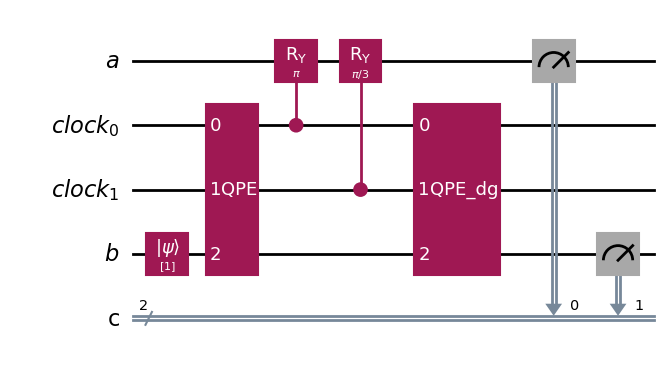

In [38]:
# Measurement
hhl.measure(a[0], classical[0])
hhl.measure(b[0], classical[1])
hhl.draw("mpl")

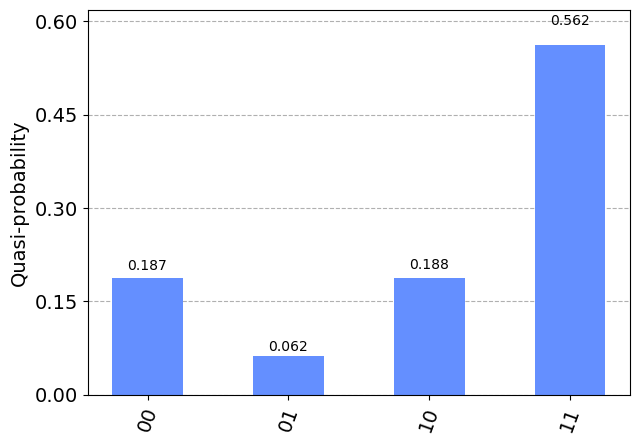

In [40]:
# Simulation
sampler = Sampler()
results = sampler.run(hhl).result()
statistics = results.quasi_dists[0].binary_probabilities()
plot_histogram(statistics)

The probability ratio of 01 (representing $x_0$) and $11$ is 1: 9.065, approximately 1: 9 (it's not preciesely 9 because we can't do infinitely many samples), thus reproducing [1].

# Reference
[1] H. J. Morrell Jr, A. Zaman, and H. Y. Wong, Step-by-Step HHL Algorithm Walkthrough to Enhance the Understanding of Critical Quantum Computing Concepts, IEEE Access 11, 77117 (2023).
